In [1]:
# Qpt

In [1]:
import pickle
import time
from typing import List
import datetime as dt
from pathlib import Path

import numpy as np
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px

from tqdm import tqdm

import numpy.testing as npt

from quara.data_analysis import data_analysis, physicality_violation_check, report
from quara.data_analysis.projected_gradient_descent_backtracking import (
    ProjectedGradientDescentBacktracking,
    ProjectedGradientDescentBacktrackingOption,
)
from quara.data_analysis.weighted_probability_based_squared_error import (
    WeightedProbabilityBasedSquaredError,
    WeightedProbabilityBasedSquaredErrorOption,
)
from quara.data_analysis.weighted_relative_entropy import (
    WeightedRelativeEntropy,
    WeightedRelativeEntropyOption,
)
from quara.objects.composite_system import CompositeSystem
from quara.objects.elemental_system import ElementalSystem
from quara.objects.matrix_basis import get_normalized_pauli_basis
from quara.objects.state import (
    State,
    get_x0_1q,
    get_x1_1q,
    get_y0_1q,
    get_y1_1q,
    get_z0_1q,
    get_z1_1q,
)
from quara.objects.povm import Povm, get_x_povm, get_y_povm, get_z_povm
from quara.objects.gate import (
    Gate,
    get_depolarizing_channel,
    get_x_rotation,
    get_amplitutde_damping_channel,
)
from quara.objects.qoperation import QOperation
from quara.protocol.qtomography.standard.standard_qpt import StandardQpt
from quara.protocol.qtomography.standard.linear_estimator import LinearEstimator
from quara.protocol.qtomography.standard.loss_minimization_estimator import (
    LossMinimizationEstimator,
)
from quara.protocol.qtomography.standard.projected_linear_estimator import (
    ProjectedLinearEstimator,
)

from quara.data_analysis.simulation import StandardQTomographySimulationSetting
from quara.settings import Settings

In [73]:
import quara.objects.state_typical as st
from quara.objects.operators import tensor_product

In [3]:
%load_ext autoreload
%autoreload 2

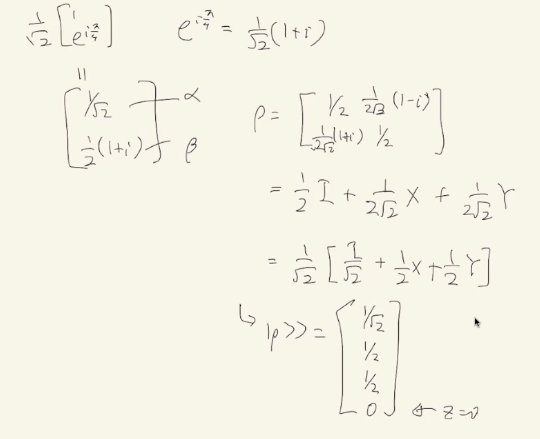

In [502]:
st.get_a_1q(c_sys).vec

array([ 0.70710678,  0.5       , -0.5       ,  0.        ])

In [511]:
st.generate_state_pure_state_vector_from_name("a")

array([0.70710678+0.j , 0.5       +0.5j])

In [512]:
st.generate_state_from_name(c_sys, "a").vec

array([0.70710678, 0.5       , 0.5       , 0.        ])

In [31]:
# setup system
e_sys = ElementalSystem(0, get_normalized_pauli_basis())
c_sys = CompositeSystem([e_sys])

state = st.generate_state_from_state_name("y0", c_sys)

In [32]:
state_x0 = get_x0_1q(c_sys)
state_y0 = get_y0_1q(c_sys)
# |0><0|
state_z0 = get_z0_1q(c_sys)
# |1><1|
state_z1 = get_z1_1q(c_sys)

In [33]:
npt.assert_almost_equal(state.vec,state_y0.vec)
assert state.composite_system == state_y0.composite_system

In [30]:
id(state.composite_system.elemental_systems[0])

4651564432

In [29]:
id(state_y0.composite_system.elemental_systems[0])

4703539792

In [218]:
from quara.objects.matrix_basis import MatrixBasis, convert_vec, get_pauli_basis

In [51]:
from itertools import product

In [143]:
state_z0z1 = st.generate_state_from_state_name("z0_z1", c_sys)

state_z0z1.composite_system.elemental_systems[0].basis.basis

(array([[0.70710678+0.j, 0.        +0.j],
        [0.        +0.j, 0.70710678+0.j]]),
 array([[0.        +0.j, 0.70710678+0.j],
        [0.70710678+0.j, 0.        +0.j]]),
 array([[0.+0.j        , 0.-0.70710678j],
        [0.+0.70710678j, 0.+0.j        ]]),
 array([[ 0.70710678+0.j,  0.        +0.j],
        [ 0.        +0.j, -0.70710678+0.j]]))

In [537]:
st.generate_state_pure_state_vector_from_name("y0")

array([0.70710678+0.j        , 0.        +0.70710678j])

In [536]:
st.generate_state_pure_state_vector_from_name("z0_x0_y0")

array([0.5+0.j , 0. +0.5j, 0.5+0.j , 0. +0.5j, 0. +0.j , 0. +0.j ,
       0. +0.j , 0. +0.j ])

In [514]:
basis = get_normalized_pauli_basis()
e_sys0 = ElementalSystem(0, basis)
e_sys1 = ElementalSystem(1, basis)
c_sys = CompositeSystem([e_sys0, e_sys1])
state_name = "z0_z0"
st.generate_state_from_name(c_sys, state_name).vec

array([0.5, 0. , 0. , 0.5, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.5,
       0. , 0. , 0.5])

In [518]:
st.get_bell_2q(c_sys)

In [515]:
st.generate_state_from_name(c_sys, "bell_psi_plus")

In [275]:
# (1) to_density_matrix()
basis = get_normalized_pauli_basis()
e_sys0 = ElementalSystem(0, basis)
e_sys1 = ElementalSystem(1, basis)
c_sys = CompositeSystem([e_sys0, e_sys1])

state_z0z1 = st.generate_state_from_state_name("z0_z1", c_sys)
state_z1z0 = st.generate_state_from_state_name("z1_z0", c_sys)

from_mat = state_z0z1.to_density_matrix() - state_z1z0.to_density_matrix()
from_mat = (1 / np.sqrt(2)) * from_mat

basis = get_pauli_basis(2)
vec = calc_hermitian_matrix_expansion_coefficient_hermitian_basis(from_mat, basis)

State(vec=vec, c_sys=c_sys)

ValueError: the state is not physically correct.

In [343]:
basis = get_normalized_pauli_basis()
e_sys0 = ElementalSystem(0, basis)
e_sys1 = ElementalSystem(1, basis)
c_sys = CompositeSystem([e_sys0, e_sys1])

st.generate_state_from_state_name("z1_z0", c_sys).dim

4

In [278]:
# (2)
basis = get_normalized_pauli_basis()
e_sys = ElementalSystem(0, basis)
c_sys = CompositeSystem([e_sys])

state_z0 =  st.generate_state_from_state_name("z0", c_sys)
state_z1 = st.generate_state_from_state_name("z1", c_sys)

_vec = (1/np.sqrt(2)) * (state_z0z1.vec - state_z1z0.vec)
from_mat = _vec.reshape(4, 4)
print(from_mat)
basis = get_pauli_basis(2)
vec = calc_hermitian_matrix_expansion_coefficient_hermitian_basis(from_mat, basis)

# tensor_product(state_z0, state_z1).vec - tensor_product(state_z1, state_z0)

[[ 0.          0.          0.         -0.70710678]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.70710678  0.          0.          0.        ]]


AssertionError: 

In [228]:
State(c_sys=c_sys, vec=vec)

ValueError: the state is not physically correct.

In [497]:
st.generate_state_from_name(c_sys, "z0").vec

array([0.70710678, 0.        , 0.        , 0.70710678])

In [164]:
from quara.objects.matrix_basis import calc_hermitian_matrix_expansion_coefficient_hermitian_basis
from quara.utils.matrix_util import is_hermitian

In [118]:
basis = get_normalized_pauli_basis()

MatrixBasis(basis=[array([[0.70710678+0.j, 0.        +0.j],
       [0.        +0.j, 0.70710678+0.j]]), array([[0.        +0.j, 0.70710678+0.j],
       [0.70710678+0.j, 0.        +0.j]]), array([[0.+0.j        , 0.-0.70710678j],
       [0.+0.70710678j, 0.+0.j        ]]), array([[ 0.70710678+0.j,  0.        +0.j],
       [ 0.        +0.j, -0.70710678+0.j]])])

In [117]:
coeff_real = calc_hermitian_matrix_expansion_coefficient_hermitian_basis(from_mat, basis)

NameError: name 'from_mat' is not defined

In [213]:
print(get_z0_1q(c_sys).vec ==  st.generate_state_from_state_name("z0", c_sys).vec)
print(get_z1_1q(c_sys).vec ==  st.generate_state_from_state_name("z1", c_sys).vec)

[ True  True  True  True]
[ True  True  True  True]


In [243]:
from scipy.linalg import expm, sinm, cosm

In [244]:
# 1qubit

In [261]:
st.generate_state_from_state_name("x0", c_sys).to_density_matrix()

array([[0.5+0.j, 0.5+0.j],
       [0.5+0.j, 0.5+0.j]])

In [262]:
st.generate_state_from_state_name("x1", c_sys).to_density_matrix()

array([[ 0.5+0.j, -0.5+0.j],
       [-0.5+0.j,  0.5+0.j]])

In [263]:
st.generate_state_from_state_name("x1", c_sys).vec

array([ 0.70710678, -0.70710678,  0.        ,  0.        ])

In [259]:
st.generate_state_from_state_name("y0", c_sys).to_density_matrix()

array([[0.5+0.j , 0. -0.5j],
       [0. +0.5j, 0.5+0.j ]])

In [269]:
z0_state.to_density_matrix()

array([[1.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j]])

In [ ]:
# 


In [286]:
# (1) 密度行列
basis = get_normalized_pauli_basis()
e_sys = ElementalSystem(0, basis)
c_sys = CompositeSystem([e_sys])

z0_state =  st.generate_state_from_state_name("z0", c_sys)
z1_state = st.generate_state_from_state_name("z1", c_sys)

z0_mat = z0_state.to_density_matrix()  # 密度行列  [[1.+0.j, 0.+0.j], [0.+0.j, 0.+0.j]]
z1_mat = z1_state.to_density_matrix()  # 密度行列 [[0.+0.j, 0.+0.j], [0.+0.j, 1.+0.j]]

mat = (1 / np.sqrt(2)) * (z0_mat + np.exp(1* np.pi / 4) * z1_mat)

print(mat) # [[0.70710678+0.j  0.+0.j ], [0.+0.j  0.5+0.5j]]

vec = calc_hermitian_matrix_expansion_coefficient_hermitian_basis(mat, basis)  # mutil.is_hermitian(from_mat) = False

# print(vec)
State(vec=vec, c_sys=c_sys)

[[0.70710678+0.j 0.        +0.j]
 [0.        +0.j 1.5508832 +0.j]]


ValueError: the state is not physically correct.

In [287]:
basis.shape

AttributeError: 'MatrixBasis' object has no attribute 'shape'

In [294]:
# (2) vec
basis = get_normalized_pauli_basis()
e_sys = ElementalSystem(0, basis)
c_sys = CompositeSystem([e_sys])

z0_state =  st.generate_state_from_state_name("z0", c_sys)
z1_state = st.generate_state_from_state_name("z1", c_sys)

z0_vec = z0_state.vec  # [0.70710678, 0.        , 0.        , 0.70710678]
z1_vec = z1_state.vec  # [ 0.70710678,  0.        ,  0.        , -0.70710678]

# |Ψ>
_vec = z0_state.vec + np.exp(np.pi / 4) * z1_state.vec
_vec = (1 / np.sqrt(2)) * _vec


# mat = _vec.reshape(2, 2)  # [[ 1.59664003  0. ] [ 0. -0.59664003]]
# print(mat)

# vec = calc_hermitian_matrix_expansion_coefficient_hermitian_basis(mat, basis)

# print(vec)

# State(vec=vec, c_sys=c_sys)

_vec * np.conjugate(_vec).T

array([2.54925937, 0.        , 0.        , 0.35597932])

In [326]:
state_vec_0 = np.array([0, 1])
state_vec_1 = np.array([1, 0])

pure_state_vec = state_vec_0 + np.exp(1j * np.pi / 4) * state_vec_1
pure_state_vec = (1 / np.sqrt(2)) * vec

pure_state_vec

array([0.5       , 0.35355339, 0.35355339, 0.        ])

In [329]:
alpha = 1 / np.sqrt(2)
beta = (1 / np.sqrt(2)) * np.exp(1j * np.pi / 4)

alpha, beta

(0.7071067811865475, (0.5+0.4999999999999999j))

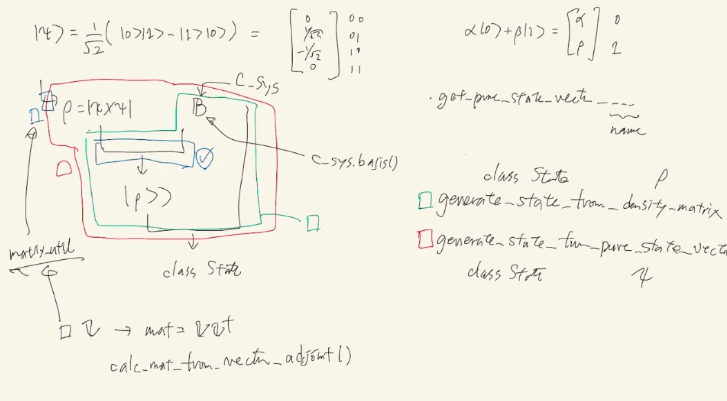

In [ ]:
def generate_state_from_density_matrix():
    

In [ ]:
# 2qubit


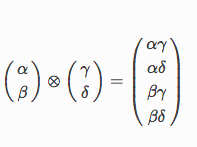

In [345]:
# d次元個できる
state_vec_00 = np.array([1, 0, 0, 0])
state_vec_01 = np.array([0, 1, 0, 0])
state_vec_10 = np.array([0, 0, 1, 0])
state_vec_11 = np.array([0, 0, 0, 1])

In [346]:
np.sqrt(1/2) * (state_vec_01 - state_vec_10)

array([ 0.        ,  0.70710678, -0.70710678,  0.        ])

In [368]:
# qubit系の場合

 state_vec_1

array([0, 0, 0, 1, 0, 0, 0, 0])

In [361]:
np.array(
    [
        state_vec_0[0] * state_vec_1[0],
        state_vec_0[0] * state_vec_1[1],
        state_vec_0[1] * state_vec_1[0],
        state_vec_0[1] * state_vec_1[1],
    ]
)

array([0, 1, 0, 0])

In [360]:
np.array(
    [
        state_vec_1[0] * state_vec_0[0],
        state_vec_1[0] * state_vec_0[1],
        state_vec_1[1] * state_vec_0[0],
        state_vec_1[1] * state_vec_0[1],
    ]
)

array([0, 0, 1, 0])

In [363]:
np.array([0, 1, 0, 0]) - np.array([0, 0, 1, 0])

array([ 0,  1, -1,  0])

In [493]:
get_z1_1q(c_sys).to_density_matrix()

array([[0.+0.j, 0.+0.j],
       [0.+0.j, 1.+0.j]])

In [494]:
st.generate_state_density_mat_from_name("z1")

array([[0, 0],
       [0, 1]])

In [487]:
st.generate_state_pure_state_vector_from_name("bell_psi_plus")

array([0.70710678, 0.        , 0.        , 0.70710678])

In [480]:
state_vecs = [state_vec_1, state_vec_0]

def tensor_product_for_vecs(state_vecs: np.array) -> np.array:
    state_vec = state_vecs[0]
    for vec in state_vecs[1:]:
        state_vec = np.kron(state_vec, vec)
    return state_vec

In [449]:
def generate_bell(name: str) -> np.array:
    name_items = name.split("_")
    error_message = f""
        
    if name_items[1] == "phi":
        vecs_0 = [state_vec_0, state_vec_1]
        vecs_1 = [state_vec_1, state_vec_0]
    elif name_items[1] == "psi":
        vecs_0 = [state_vec_0, state_vec_0]
        vecs_1 = [state_vec_1, state_vec_1]
    else:
        raise ValueError(error_message)
    
    pure_state_vec = tensor_product_for_vecs(vecs_0)
    if name_items[2] == "plus":
        pure_state_vec += tensor_product_for_vecs(vecs_1)
    elif name_items[2] == "minus":
        pure_state_vec -= tensor_product_for_vecs(vecs_1)
    else:
        raise ValueError(error_message)
    pure_state_vec = 1/ np.sqrt(2) * pure_state_vec

    return pure_state_vec

In [447]:
pure_state_vec = generate_bell("bell_phi_plus")
state = generate_state_from_pure_state(pure_state_vec, c_sys)

pure_state_vec = generate_bell("bell_phi_minus")
state = generate_state_from_pure_state(pure_state_vec, c_sys)

pure_state_vec = generate_bell("bell_psi_plus")
state = generate_state_from_pure_state(pure_state_vec, c_sys)

pure_state_vec = generate_bell("bell_psi_minus")
state = generate_state_from_pure_state(pure_state_vec, c_sys)

In [452]:
e_sys = ElementalSystem(0, basis)
c_sys = CompositeSystem([e_sys])

pure_state_vec = np.array([1, 0])
state = generate_state_from_pure_state(pure_state_vec, c_sys)
state.vec

array([0.70710678, 0.        , 0.        , 0.70710678])

In [455]:
pure_state_vec = np.array([0, 1])
state = generate_state_from_pure_state(pure_state_vec, c_sys)
state.vec

array([ 0.70710678,  0.        ,  0.        , -0.70710678])

In [468]:
pure_state_vec = np.array([0.5, 0.5])
state = generate_state_from_pure_state(pure_state_vec, c_sys)
state.vec

ValueError: the state is not physically correct.

In [478]:
get_x0_1q(c_sys).to_density_matrix()

array([[0.5+0.j, 0.5+0.j],
       [0.5+0.j, 0.5+0.j]])

In [474]:
# x0
coef = [1, 1, 0, 0]
I = np.array([[1, 0], [0, 1]])
X = np.array([[0, 1], [1, 0]])
Y = np.array([[0, -1j], [1j, 0]])
Z =  np.array([[1, 0], [0, -1]])

coef[0] * I + coef[1] * X + coef[2] * Y + coef[3] *Z

array([[1.+0.j, 1.+0.j],
       [1.+0.j, 1.+0.j]])

[1, 0, -1, 0]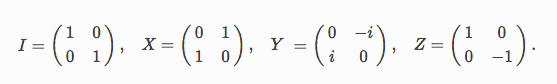

In [439]:
pure_state_vec_2qubit = tensor_product_for_vecs(
    [state_vec_0, state_vec_1]
) - tensor_product_for_vecs([state_vec_1, state_vec_0])
pure_state_vec_2qubit = (1 / np.sqrt(2)) * pure_state_vec_2qubit

basis = get_normalized_pauli_basis()
e_sys0 = ElementalSystem(0, basis)
e_sys1 = ElementalSystem(1, basis)
c_sys = CompositeSystem([e_sys0, e_sys1])

generate_state_from_pure_state(pure_state_vec_2qubit, c_sys)

In [431]:
pure_state_vec_2qubit = np.kron(state_vec_0, state_vec_1) - np.kron(state_vec_1, state_vec_0)
pure_state_vec_2qubit = (1 / np.sqrt(2)) * pure_state_vec_2qubit

pure_state_vec_2qubit

array([ 0.        ,  0.70710678, -0.70710678,  0.        ])

In [340]:
# d=2の場合はalphaとbetaに分けられるけど、d=4だとどうなる？

array([0, 0])

In [403]:
def calc_mat_from_vector_adjoint_1qubit(pure_state_vec):
    alpha = pure_state_vec[0]
    beta = pure_state_vec[1]
    
    density_matrix = np.array(
    [
        [abs(alpha) ** 2, alpha * np.conjugate(beta)],
        [np.conjugate(alpha) * beta, abs(beta) ** 2],
    ]
)
    return density_matrix

In [399]:
def calc_mat_from_vector_adjoint(pure_state_vec: np.array) -> np.array:
    # TODO: matrix_utilに移動させる
    _vec = np.kron(pure_state_vec, np.conjugate(pure_state_vec).T)
    dim = int(np.sqrt(_vec.shape[0]))
    mat = _vec.reshape((dim, dim))
    return mat

In [429]:
def calc_mat_from_vector_adjoint(pure_state_vec: np.array) -> np.array:
    # TODO: matrix_utilに移動させる
    _vec = np.kron(pure_state_vec, np.conjugate(pure_state_vec).T)
    dim = int(np.sqrt(_vec.shape[0]))
    mat = _vec.reshape((dim, dim))
    return mat

def generate_state_from_density_matrix(density_matrix: np.array, c_sys: CompositeSystem) -> State:
    # 密度行列からベクトルに変換する
    vec = calc_hermitian_matrix_expansion_coefficient_hermitian_basis(
        density_matrix, c_sys.basis()
    )
    state = State(vec=vec, c_sys=c_sys)
    return state

def generate_state_from_pure_state(pure_state_vec: np.array, c_sys: CompositeSystem) -> State:
    # 純粋な状態ベクトルから密度行列に変換する
    density_matrix = calc_mat_from_vector_adjoint(pure_state_vec)
    state = generate_state_from_density_matrix(density_matrix, c_sys)
    return state

def generate_state_a(c_sys) -> State:
    state_vec_0 = np.array([1, 0])
    state_vec_1 = np.array([0, 1])
    
    pure_state_vec = state_vec_0 + np.exp(1j * np.pi / 4) * state_vec_1
    pure_state_vec = (1 / np.sqrt(2)) * pure_state_vec

    state_a = generate_density_matrix_from_pure_state_vec(pure_state_vec)
    return state_a

In [430]:
generate_state_a(c_sys)

array([[0.5       +0.j        , 0.35355339-0.35355339j],
       [0.35355339+0.35355339j, 0.5       +0.j        ]])

In [427]:
# 入力
e_sys = ElementalSystem(0, basis)
c_sys = CompositeSystem([e_sys])

# 用意(1qubitの場合)
state_vec_0 = np.array([1, 0])
state_vec_1 = np.array([0, 1])

# 純粋な状態ベクトルを作る
pure_state_vec = state_vec_0 + np.exp(1j * np.pi / 4) * state_vec_1
pure_state_vec = (1 / np.sqrt(2)) * pure_state_vec

generate_density_matrix_from_pure_state_vec(pure_state_vec)

array([[0.5       +0.j        , 0.35355339-0.35355339j],
       [0.35355339+0.35355339j, 0.5       +0.j        ]])

In [423]:
# 入力
e_sys = ElementalSystem(0, basis)
c_sys = CompositeSystem([e_sys])

# 用意(1qubitの場合)
state_vec_0 = np.array([1, 0])
state_vec_1 = np.array([0, 1])

# 純粋な状態ベクトルを作る
pure_state_vec = state_vec_0 + np.exp(1j * np.pi / 4) * state_vec_1
pure_state_vec = (1 / np.sqrt(2)) * pure_state_vec

# 純粋な状態ベクトルから密度行列に変換する
density_matrix = calc_mat_from_vector_adjoint(pure_state_vec)
print(density_matrix)
print("==================")

print(calc_mat_from_vector_adjoint_1qubit(pure_state_vec))

# 密度行列からベクトルに変換する
vec = calc_hermitian_matrix_expansion_coefficient_hermitian_basis(
    density_matrix, c_sys.basis()
)

print(vec)

# Stateを生成する
state = State(vec=vec, c_sys=c_sys)

[[0.5       +0.j         0.35355339-0.35355339j]
 [0.35355339+0.35355339j 0.5       +0.j        ]]
[[0.5       +0.j         0.35355339-0.35355339j]
 [0.35355339+0.35355339j 0.5       +0.j        ]]
[0.70710678 0.5        0.5        0.        ]


In [498]:
vec = [0, 0, 0, 1]
np.array([vec]).T @ np.array([vec]).conjugate()

array([[0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 1]])

In [499]:
np.array([vec])

array([[0, 0, 0, 1]])

In [393]:
np.kron(pure_state_vec, np.conjugate(pure_state_vec).T)

array([0.5       +0.j        , 0.35355339-0.35355339j,
       0.35355339+0.35355339j, 0.5       +0.j        ])

In [390]:
np.kron(pure_state_vec, np.conjugate(pure_state_vec).T)

array([0.5       +0.j        , 0.35355339-0.35355339j,
       0.35355339+0.35355339j, 0.5       +0.j        ])

In [406]:
calc_mat_from_vector_adjoint_1qubit(pure_state_vec)

array([[0.5       +0.j        , 0.35355339-0.35355339j],
       [0.35355339+0.35355339j, 0.5       +0.j        ]])

In [414]:
density_matrix = np.array(
    [
        [abs(alpha) ** 2, alpha * np.conjugate(beta)],
        [np.conjugate(alpha) * beta, abs(beta) ** 2],
    ]
)

density_matrix

array([[0.5       +0.j        , 0.35355339-0.35355339j],
       [0.35355339+0.35355339j, 0.5       +0.j        ]])

In [413]:
1/ (2 * np.sqrt(2))

0.35355339059327373

In [415]:
vec = calc_hermitian_matrix_expansion_coefficient_hermitian_basis(density_matrix, basis)

State(vec=vec, c_sys=c_sys)

In [351]:
pure_state_vec * np.conjugate(pure_state_vec)

array([0.5+0.j, 0.5+0.j])

In [ ]:
_vec  = (np.array([1, 0, 0, 1]) + np.exp(np.pi / 4) * np.array([1, 0, 0, -1]))
_vec  =  (1 / np.sqrt(2)) * _vec

mat = _vec.reshape(2, 2)

print(mat)

vec = calc_hermitian_matrix_expansion_coefficient_hermitian_basis(mat, basis)